#  One-Shot Learning for plan symbols

## Overview

One-shot learning approach based on SimCLR embeddings:


Training (unsupervised):
- dataset of unlabeled images
- for each image: generation of two augmented views using strong transforms (random crop-resize, color jitter, horizontal flip). A batch of N images becomes 2N views
- model optimize the NT-Xent contrastive loss, to increase similarity between the two views of the same image (positive pair) and pushes apart all other images in the batch (negative pairs)


Architecture:
- ResNet_backbone + Projection head(Linear + ReLU + Linear)
- Head removed for inference

Inference (one example per class):
- The user provides one reference image per class.
- New image encoded with the backbone and classified using nearest-neighbor with cosine similarity in the embedding space.


Reference: SimCLR (Chen et al., 2020) — https://arxiv.org/abs/2002.05709





However, this self-supervised approach has an important limitation:
- SimCLR treats all different images as negatives, even when two samples belong to the same class.
- Without labels, same-class images are pushed apart instead of being pulled together.

Supervised contrastive learning addresses this:
- Labels allow treating same-class samples as positive pairs.
- This produces tighter class clusters and generally improves classification.

In this work:
- The training set was assumed unlabeled, so SimCLR was the appropriate choice.

In practice, labeled data is costly, making self-supervised methods attractive despite their limitations.

Reference: Supervised Contrastive Learning (Khosla et al., 2020) — https://arxiv.org/pdf/2004.11362



In [1]:
!pip install torch
!pip install timm
!pip install roboflow
!pip install matplotlib
!pip install scikit-learn 
!pip install math 


  Using cached roboflow-1.2.11-py3-none-any.whl.metadata (9.7 kB)
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
  Using cached pi_heif-0.18.0.tar.gz (16.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pillow_avif_plugin-1.5.2-cp38-cp38-macosx_11_0_arm64.whl.metadata (1.9 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached filetype-1.2.0-py2.py3-none-any.whl.metadata (6.5 kB)
Using cached roboflow-1.2.11-py3-none-any.whl (89 kB)
Using cached idna-3.7-py3-none-any.whl (66 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl (54.8 MB)
Using cached pillow_avif_plugin-1.5.2-cp38-cp38-macosx_11_0_arm64.whl (2.8 MB)
Using cached filetype-1

In [1]:
import os
from PIL import Image

import torch
import torchvision.transforms  as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

import numpy as np

from sklearn.manifold import TSNE


import random

import math

from tqdm import tqdm


from IPython.display import clear_output

## Data processing

In [3]:
'''1'''
'''The link may expire and also may not work if no roboflow account'''
if not os.path.exists("firefighting-device-detection"):
    !wget "https://universe.roboflow.com/ds/EvHxmLAvmh?key=skA3n0O0ky" -O firefighting-device-detection.zip
    !unzip -q firefighting-device-detection.zip -d firefighting-device-detection
    !rm firefighting-device-detection.zip
else:
    print("Dataset already loaded")


Dataset already loaded


In [4]:
from roboflow import Roboflow
import roboflow as rf

'''2'''
'''If Roboflow API key'''
if not os.path.exists("firefighting-device-detection"):
    rf = Roboflow(api_key="")
    project = rf.workspace("yaid-pzikt").project("firefighting-device-detection")
    dataset = project.version(6).download("yolov8",location="firefighting-device-detection")
else:
    print("Dataset already loaded")

ModuleNotFoundError: No module named 'roboflow'

### Cropping the symbols


To focus on the symbols themselves, we extract crops using the bounding boxes produced by YOLO.  
As SimCLR is self-supervised, the labels are not needed during training.


In [5]:
class YoloCropExtractor:
    def __init__(self, root_dir):
        self.img_dir = os.path.join(root_dir, "images")
        self.label_dir = os.path.join(root_dir, "labels")
        self.save_dir = os.path.join(root_dir, "images_cropped")
        os.makedirs(self.save_dir, exist_ok=True)

    def extract(self):
        for fname in sorted(os.listdir(self.img_dir)):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            img_path = os.path.join(self.img_dir, fname)
            label_path = os.path.join(self.label_dir, fname).replace(".jpg", ".txt").replace(".png", ".txt")
            if not os.path.exists(label_path):
                continue

            image = Image.open(img_path).convert("RGB")
            W, H = image.size

            with open(label_path, "r") as f:
                for i, line in enumerate(f.readlines()):

                    parts = [p for p in line.strip().split() if p]
                    if len(parts) != 5:
                        continue
                    cls, x, y, w, h = map(float, parts)
                    x1, y1 = int((x - w / 2) * W), int((y - h / 2) * H)
                    x2, y2 = int((x + w / 2) * W), int((y + h / 2) * H)
                    crop = image.crop((x1, y1, x2, y2))
                    crop_filename = f"{os.path.splitext(fname)[0]}_{i}_cls{int(cls)}.jpg"
                    crop.save(os.path.join(self.save_dir, crop_filename))


In [6]:
root_dir = "firefighting-device-detection/train"
extractor_train = YoloCropExtractor(root_dir)
extractor_train.extract()

root_dir = "firefighting-device-detection/valid"
extractor_valid = YoloCropExtractor(root_dir)
extractor_valid.extract()

root_dir = "firefighting-device-detection/test"
extractor_test = YoloCropExtractor(root_dir)
extractor_test.extract()

To better understand the dataset, we inspect a few randomly selected crops:

- The dataset is very small (~2500 crops).  
- Many images are visually almost identical, since they correspond to the same symbol.  
- This lack of visual diversity will makes it harder for the contrastive model to learn strongly discriminative representations
- Same-class images form very tight visual clusters, so the contrastive objective must be tuned carefully to avoid pushing these samples apart and degrading the structure of the embedding space.

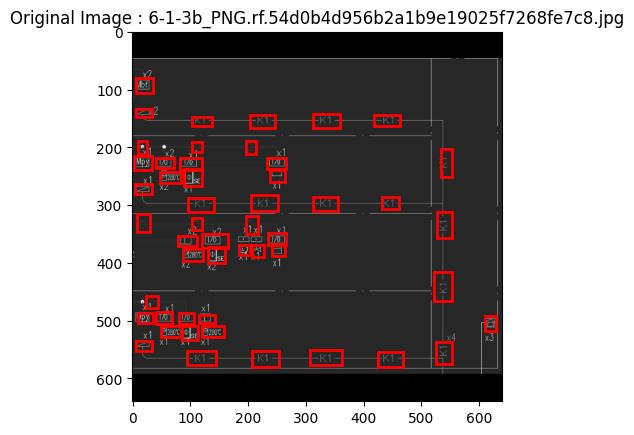

Base name used for matching: 6-1-3b_PNG.rf.54d0b4d956b2a1b9e19025f7268fe7c8
Cropped dir: firefighting-device-detection/train/images_cropped

50 crops found in 6-1-3b_PNG.rf.54d0b4d956b2a1b9e19025f7268fe7c8.jpg


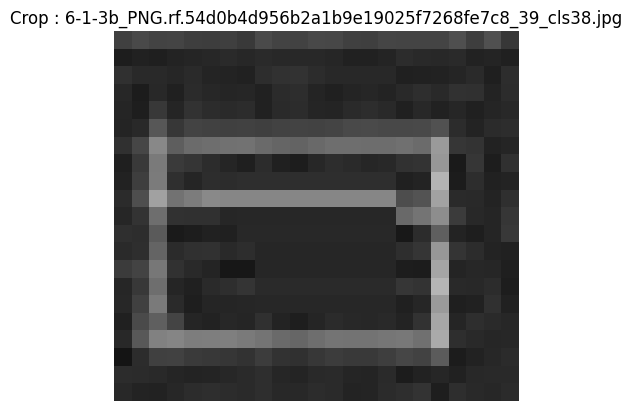

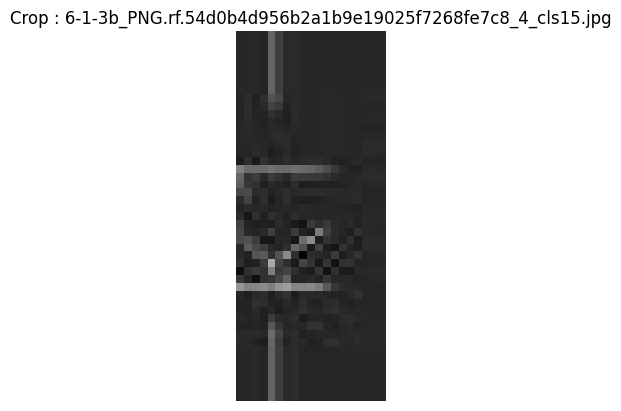

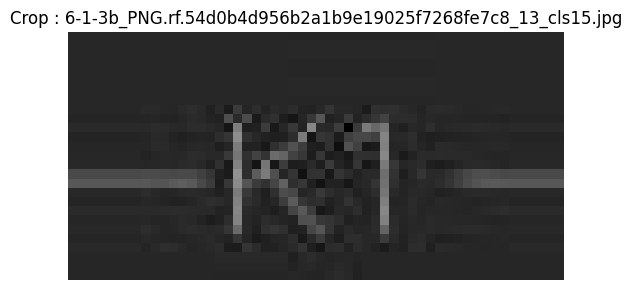

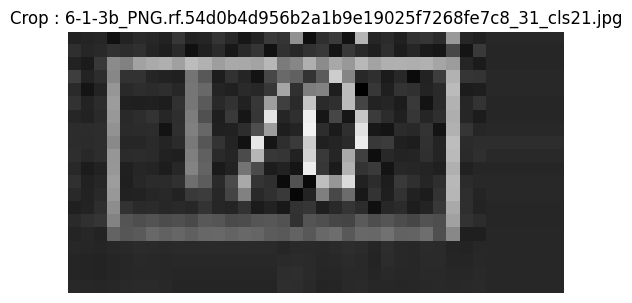

In [7]:
img_files = [f for f in os.listdir(extractor_train.img_dir) if f.endswith((".jpg", ".png"))]
random_img = random.choice(img_files)
img_path = os.path.join(extractor_train.img_dir, random_img)
label_path = os.path.join(extractor_train.label_dir, random_img).replace(".jpg", ".txt").replace(".png", ".txt")

image = Image.open(img_path).convert("RGB")
W, H = image.size

fig, ax = plt.subplots(1)
ax.imshow(image)
ax.set_title(f"Original Image : {random_img}")

if os.path.exists(label_path):
    with open(label_path, "r") as f:
        for line in f.readlines():
            cls, x, y, w, h = map(float, line.strip().split())
            x1, y1 = (x - w/2) * W, (y - h/2) * H
            rect = patches.Rectangle((x1, y1), w * W, h * H,
                                        linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

plt.show()

base_name = os.path.splitext(random_img)[0]
print("Base name used for matching:", base_name)
print("Cropped dir:", extractor_train.save_dir)
cropped_files = [f for f in os.listdir(extractor_train.save_dir) if base_name in f]

print(f"\n{len(cropped_files)} crops found in {random_img}")

for crop_file in cropped_files[:4]:
    crop = Image.open(os.path.join(extractor_train.save_dir, crop_file))
    plt.imshow(crop)
    plt.title(f"Crop : {crop_file}")
    plt.axis('off')
    plt.show()


In [2]:
class CroppedSimCLRDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.cropped_dir = os.path.join(root_dir, "images_cropped")
        self.transform = transform
        self.image_files = sorted([
            os.path.join(self.cropped_dir, f)
            for f in os.listdir(self.cropped_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img = Image.open(self.image_files[idx]).convert("RGB")
        if self.transform:
            img1 = self.transform(img)
            img2 = self.transform(img)
        else:
            img1 = img
            img2 = img
        return img1, img2


### Transformations used during training

**augmentation_transform**  
Used to generate the two augmented views required by SimCLR.  
It includes:
- random resized crop  
- random horizontal flip  
- random color jitter (brightness, contrast, saturation)  
- random grayscale  
- **no Gaussian blur** because the symbol crops are low-resolution and contain fine line details that would be lost  



**conversion_transform**  
Used to ensure that images follow the formatting expected by ResNet:
- resizing / normalization  
- consistent preprocessing with ImageNet-trained weights

In [22]:

augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(13)
])

conversion_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

transform=transforms.Compose([augmentation_transform,conversion_transform])

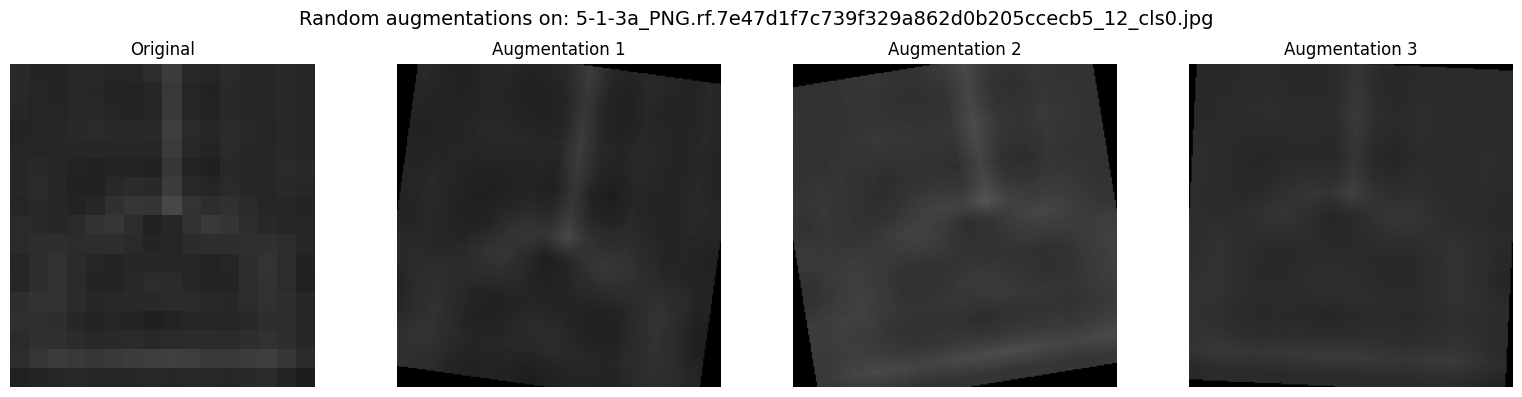

In [10]:
'''We check the transformation to gain more intution but in reality they are only applied at the very end by the DataLoader.
'''
cropped_dir = extractor_train.save_dir

img_files = [f for f in os.listdir(cropped_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
random_img = random.choice(img_files)
img_path = os.path.join(cropped_dir, random_img)

img = Image.open(img_path).convert("RGB")

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis("off")

for i in range(1, 4):
    aug_img = augmentation_transform(img)
    axes[i].imshow(aug_img)
    axes[i].set_title(f"Augmentation {i}")
    axes[i].axis("off")

plt.suptitle(f"Random augmentations on: {random_img}", fontsize=14)
plt.tight_layout()
plt.show()

## Model Architecture

### Model choices

Two architectural choices had to be made:

- **Backbone:** ResNet18 vs. ResNet50  
- **Embedding dimensionality:** 128 vs. 256  

Given the small dataset (~3000 images) and limited compute budget, **ResNet18 with a 128-dimensional embedding** is the most reasonable option.  
ResNet18 has roughly **11M parameters**, which is already large relative to the size of the dataset.  
SimCLR partially compensates for this by generating **two strongly augmented views** of each image at every epoch, increasing the effective diversity seen during training.

---

### Initialization

We initialize the backbone with **ImageNet pretrained weights**, which stabilizes training


In [7]:
class ResNetSimCLR(nn.Module):
    def __init__(self, base_model="resnet18", out_dim=128):
        super().__init__()
        base = getattr(models, base_model)(weights="IMAGENET1K_V1")
        dim_mlp = base.fc.in_features
        base.fc = nn.Sequential(
            nn.Linear(dim_mlp, dim_mlp),
            nn.ReLU(),
            nn.Linear(dim_mlp, out_dim)
        )
        self.backbone = base

    def forward(self, x):
        return self.backbone(x)

### NT-Xent (InfoNCE) Loss

The contrastive loss used in SimCLR is defined as:

$$
\mathcal{L} = \frac{1}{2N} \sum_{i=1}^{2N}
-\log \frac{\exp\left( \text{sim}(z_i, z_{i}^{+}) / \tau \right)}
{\sum_{\substack{k=1 \\ k\neq i}}^{2N} \exp\left(\text{sim}(z_i, z_k)/\tau\right)}
$$



Increasing in the temperature: model less discriminative between the positive and the negative

Some extensions of contrastive learning use triplets of transformations instead of couples, which can help when the dataset is small. These variants were not explored here due to time constraints but could be relevant in this context.

In [5]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.3):
        super().__init__()
        self.temperature = temperature

    def forward(self, z1, z2):

        batch_size = z1.size(0)
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)
        z = torch.cat([z1, z2], dim=0)
        sim = torch.matmul(z, z.T) / self.temperature
        mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
        sim = sim.masked_fill(mask, float('-inf'))
        pos_idx = torch.arange(batch_size, device=z.device)
        pos_idx = torch.cat([pos_idx + batch_size, pos_idx], dim=0)
        positives = torch.exp(sim[torch.arange(2*batch_size), pos_idx])
        denominators = torch.exp(sim).sum(dim=1)
        loss = -torch.log(positives / denominators)

        return loss.mean()

## Hyperparameters and training strategy


Although SimCLR does not overfit like a supervised classifier (no decision boundaries), it can still overfit at the representation level:
- Contrastive learning shapes the embedding space rather than predicting labels.
- With a small, low-diversity dataset, this process can become unstable.
- Training and validation losses may both decrease while the model overfits the structure of the data.
- The model may over-separate individual samples, pushing same-class images too far apart.
- This excessive repulsion can break natural clusters and degrade the embedding space.
A decreasing validation contrastive loss does not guarantee that the learned invariances remain meaningful.

These considerations make hyperparameter choices particularly critical:

- **Temperature (τ):**  
  Must not be too low. Since cross-class images are already visually distinct, a low temperature would amplify repulsion and **break clusters**.  
  A moderate range (**0.5–0.7**) proved more stable.

- **Regularization:**  
  A light weight decay (**10⁻⁵ to 10⁻⁶**) is sufficient.  
  Too much regularization would pull the model away from the useful ImageNet initialization.  
  **AdamW** was chosen for its stable handling of weight decay.

- **Number of epochs:**  
  With a very small and low-diversity dataset, training too long increases the risk of representation overfitting.  
  A short schedule is safer.
  We also make sur to save the model at each epochs

- **Learning rate:**  
  Initialized at **1e-4**, then controlled via a scheduler to reduce sensitivity and avoid instability during early training.

- **Batch size** strongly impacts SimCLR since larger batches provide more negative    
  samples. Tested values: **64 and 128**.  

- **Backbone freezing strategy:**  
  ResNet layers 1–3 were frozen, and only **layer 4 + projection head** were trained.  
  This preserves the strong ImageNet features while allowing the upper layers to adapt.
  This approach is justified because ResNet’s lower layers  learn universal low-level primitives that are reused across tasks. And layer 4 only still accounts for around 8M parameters

All these decisions emerged from **iterative experimentation and errors**: repeatedly visualizing validation embeddings before and after training, comparing them to the baseline embeddings from the raw ImageNet backbone, and adjusting the setup until the representation structure became stable.


In [17]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr=0.0001
temperature=0.6
base_model='resnet18'
out_dim=128
weight_decay=0.000001
batch_size=64
num_epochs=5
adam_with_weight_decay=True
with_scheduler=True


model_hp = ResNetSimCLR(base_model=base_model,out_dim=out_dim).to(device)


for name, param in model_hp.backbone.named_parameters():
    param.requires_grad = False

for name, param in model_hp.backbone.layer4.named_parameters():
    param.requires_grad = True

for name, param in model_hp.backbone.fc.named_parameters():
    param.requires_grad = True

params_to_train = [p for p in model_hp.parameters() if p.requires_grad]



criterion = NTXentLoss(temperature=temperature)


if adam_with_weight_decay:
  optimizer = optim.AdamW(params_to_train, lr=lr, weight_decay=weight_decay)
else:
  optimizer = optim.Adam(params_to_train, lr=lr)

if with_scheduler:
  def warmup_cosine_scheduler(optimizer, num_epochs, warmup_ratio=0.1, lr_min_ratio=0.2):
      warmup_epochs = int(num_epochs * warmup_ratio)
      cosine_epochs = num_epochs - warmup_epochs

      def lr_lambda(epoch):
          if epoch < warmup_epochs:
              return epoch / warmup_epochs
          else:
              progress = (epoch - warmup_epochs) / cosine_epochs
              cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
              return lr_min_ratio + (1 - lr_min_ratio) * cosine_decay

      return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

  scheduler = warmup_cosine_scheduler(optimizer, num_epochs=num_epochs)

train_set=CroppedSimCLRDataset(root_dir="./firefighting-device-detection/train",transform=transform)
train_loader=DataLoader(train_set,batch_size=batch_size,shuffle=True, num_workers=4,pin_memory=True,persistent_workers=True)

validation_set=CroppedSimCLRDataset(root_dir="./firefighting-device-detection/valid",transform=transform)
validation_loader=DataLoader(validation_set,batch_size=batch_size,shuffle=True, num_workers=4,pin_memory=True,persistent_workers=True)

Live plotting of the loss to potentially stop before the end


In [ ]:
'''Live plotting of the loss so that I can stop before the end. '''

train_losses = []
val_losses = []

plt.ion()

for epoch in range(num_epochs):
    model_hp.train()
    training_loss = 0.0
    for images_T1, images_T2 in train_loader:
        images_T1, images_T2 = images_T1.to(device), images_T2.to(device)
        outputs_T1 = model_hp(images_T1)
        outputs_T2 = model_hp(images_T2)
        loss = criterion(outputs_T1, outputs_T2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Training loss for epoch {epoch+1}: {avg_train_loss:.4f}")

    model_hp.eval()
    validation_loss = 0

    with torch.no_grad():
        for images_T1, images_T2 in validation_loader:
            images_T1, images_T2 = images_T1.to(device), images_T2.to(device)
            outputs_T1 = model_hp(images_T1)
            outputs_T2 = model_hp(images_T2)
            loss = criterion(outputs_T1, outputs_T2)
            validation_loss += loss.item()
    avg_val_loss = validation_loss / len(validation_loader)
    val_losses.append(avg_val_loss)
    print(f"Validation loss for epoch {epoch+1}: {avg_val_loss:.4f}")
    if with_scheduler:
      scheduler.step()
    
    torch.save(model_hp.state_dict(), f"temps_epoch{epoch}.pth")

    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.pause(0.1)

plt.ioff()

if with_scheduler:
  if adam_with_weight_decay:
    filename = f"layer4only_loss_curve_adamw_scheduler_model={base_model}_out{out_dim}_lr{lr}_temp{temperature}_w{weight_decay}_batch{batch_size}.png"
  else:
    filename = f"layer4only_loss_curve_scheduler_model={base_model}_out{out_dim}_lr{lr}_temp{temperature}_w{weight_decay}_batch{batch_size}.png"
else:
  if adam_with_weight_decay:
    filename = f"layer4only_loss_curve_adamw_model={base_model}_out{out_dim}_lr{lr}_temp{temperature}_w{weight_decay}_batch{batch_size}.png"
  else:
    filename = f"layer4only_loss_curve_model={base_model}_out{out_dim}_lr{lr}_temp{temperature}_w{weight_decay}_batch{batch_size}.png"

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training vs Validation Loss (model={base_model},out_dim={out_dim},lr={lr},_w{weight_decay},batch{batch_size}")
plt.legend()
plt.grid(True)
plt.savefig(filename, bbox_inches='tight')
print(f"Saved plot as {filename}")

In [258]:
if with_scheduler:
  if adam_with_weight_decay:
    filename = f"l4temp_weights_adamw_scheduler_model=batch{batch_size}_temp{temperature}_lr{lr}_w{weight_decay}_epochs{num_epochs}.pth"
  else:
    filename = f"l4temp_weight_scheduler_model=batch{batch_size}_temp{temperature}_lr{lr}_w{weight_decay}_epochs{num_epochs}.pth"
else:
  if adam_with_weight_decay:
    filename = f"l4temp_weights_adamw_model={base_model}_out{out_dim}_batch{batch_size}_temperature{temperature}_lr{lr}_w{weight_decay}_epochs{num_epochs}.pth"
  else:
    filename = f"l4temp_weights_model={base_model}_out{out_dim}_batch{batch_size}_temperature{temperature}_lr{lr}_w{weight_decay}_epochs{num_epochs}.pth"
torch.save(model_hp.state_dict(), filename)

### Test of the performances on the validation set


- Many hyperparameter combinations produced a decreasing validation contrastive loss, but this was misleading.  
- Visualizing the embeddings showed that several settings **broke the natural clusters**, pushing same-class samples too far apart.  
- These configurations often **reduced accuracy**, sometimes below the reference baseline (ResNet18 features ≈ 70%).  
- For this use case, the contrastive loss alone was therefore **not a reliable criterion**: both cluster structure and nearest-neighbor accuracy had to be monitored.  



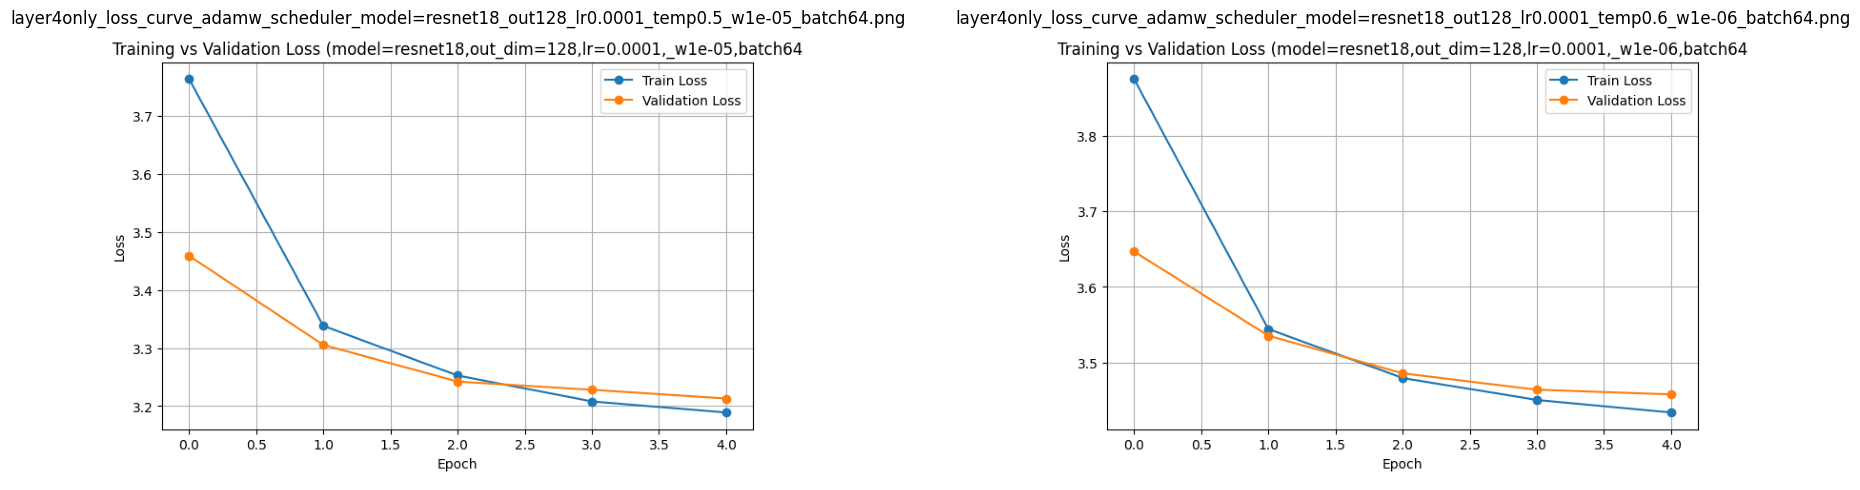

In [18]:
images = [
    "layer4only_loss_curve_adamw_scheduler_model=resnet18_out128_lr0.0001_temp0.5_w1e-05_batch64.png",
    "layer4only_loss_curve_adamw_scheduler_model=resnet18_out128_lr0.0001_temp0.6_w1e-06_batch64.png"
]

plt.figure(figsize=(20, 5))

for i, img_path in enumerate(images):
    img = mpimg.imread(img_path)
    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_path)

plt.tight_layout()
plt.show()


For this experiment, both training and validation losses decrease smoothly for the two models. The only differences are the temperature and the (very small) weight decay.  
Lowering the temperature to **τ = 0.5** reduced the contrastive loss, but this did not translate into better representations.  
When evaluating the downstream accuracy using only the ResNet18 backbone (reference baseline ≈ 70%), we observed:

- **τ = 0.6** slightly increased accuracy compared to the baseline.
- **τ = 0.5** decreased accuracy, even though the loss was lower.

On such a small and low-diversity dataset, a lower contrastive loss does not necessarily imply better embeddings. Checking the cluster structure and downstream accuracy is essential for selecting the right hyperparameters.

- After extensive testing, the configuration that preserved clusters and slightly improved accuracy was:  
  **temperature = 0.6**, **weight decay = 1e-6**, **lr = 1e-4**, **batch size = 64**, and **0–5 training epochs**.


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model='resnet18'
out_dim=128

reference_extractor = ResNetSimCLR(base_model='resnet18',out_dim=out_dim).to(device)
reference_extractor.backbone.fc = nn.Identity()  
feature_extractor_temp = ResNetSimCLR(base_model=base_model,out_dim=out_dim).to(device)
weights_file_temp="temps_epoch5.pth"
model_state_dict = torch.load(weights_file_temp, map_location='cpu')
feature_extractor_temp.load_state_dict(model_state_dict, strict=True)
feature_extractor_temp.backbone.fc = nn.Identity()

/var/folders/t9/q84x_b1n3xjgf7jpkdvlr4n00000gn/T/ipykernel_58851/286975242.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(weights_file_tem

We first visualize how much the weights in **layer4** were modified during training.  
By plotting the ratio *after-training weights / before-training weights* (clipped between –3 and 3):
- We checked that Layer4 is indeed the only part of the network that changed. 
- The majority of the weights stayed in a controlled range relative to their initial values, as we wanted
- The ratio visualization also allow to check weights that  “blew up” or collapsed during optimization.


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def weights_comparison(model_before,model_after, save_path=None):
    params_before = dict(model_before.named_parameters())
    params_after  = dict(model_after.named_parameters())
    
    for name, w_before in params_before.items():

        if not name.startswith("backbone.layer4"):
            continue
        
        w_before = w_before.detach().cpu().numpy()
        w_after  = params_after[name].detach().cpu().numpy()
    
        if w_before.shape != w_after.shape:
            continue
    
        ratio = w_after / w_before
    
        if ratio.ndim == 1:
            print(f"[SKIP] 1D layer: {name}")
            continue
    
        if ratio.ndim == 2:
            print("2DDDDDf")
    
            plt.figure(figsize=(5,4))
            im = plt.imshow(ratio, cmap="inferno")
            plt.colorbar(im)  
            plt.title(f"{name}")
            plt.show()
            continue
    
        if ratio.ndim == 3:
            print("333DDDDDf")
            C, H, W = ratio.shape
            cols = 8
            rows = int(np.ceil(C / cols))
    
            plt.figure(figsize=(cols*2, rows*2))
            for i in range(C):
                plt.subplot(rows, cols, i+1)
                im = plt.imshow(ratio[i], cmap="inferno")
                plt.axis("off")
                plt.colorbar(im)  # Afficher l'échelle de couleur pour chaque filtre
            plt.suptitle(f"{name}")
            plt.show()
            continue
    
        if ratio.ndim == 4:
            ratio2 = ratio.mean(axis=1)  
    
            C, H, W = ratio2.shape
            cols = 30 
            rows = int(np.ceil(C / cols))  
    
            vmin, vmax = -3, 3
    
            plt.figure(figsize=(cols * 2, rows * 2))
    
            idx = 1
            for i in range(C):
                if i % 5 == 0:  
                    plt.subplot(rows, cols, idx) 
                    im = plt.imshow(ratio2[i], cmap="inferno", vmin=vmin, vmax=vmax)  
                    plt.axis("off")
                    plt.colorbar(im)  
                    idx += 1  
    
            plt.suptitle(f"{name}")
            plt.show()
            continue
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved t-SNE figure to: {save_path}")

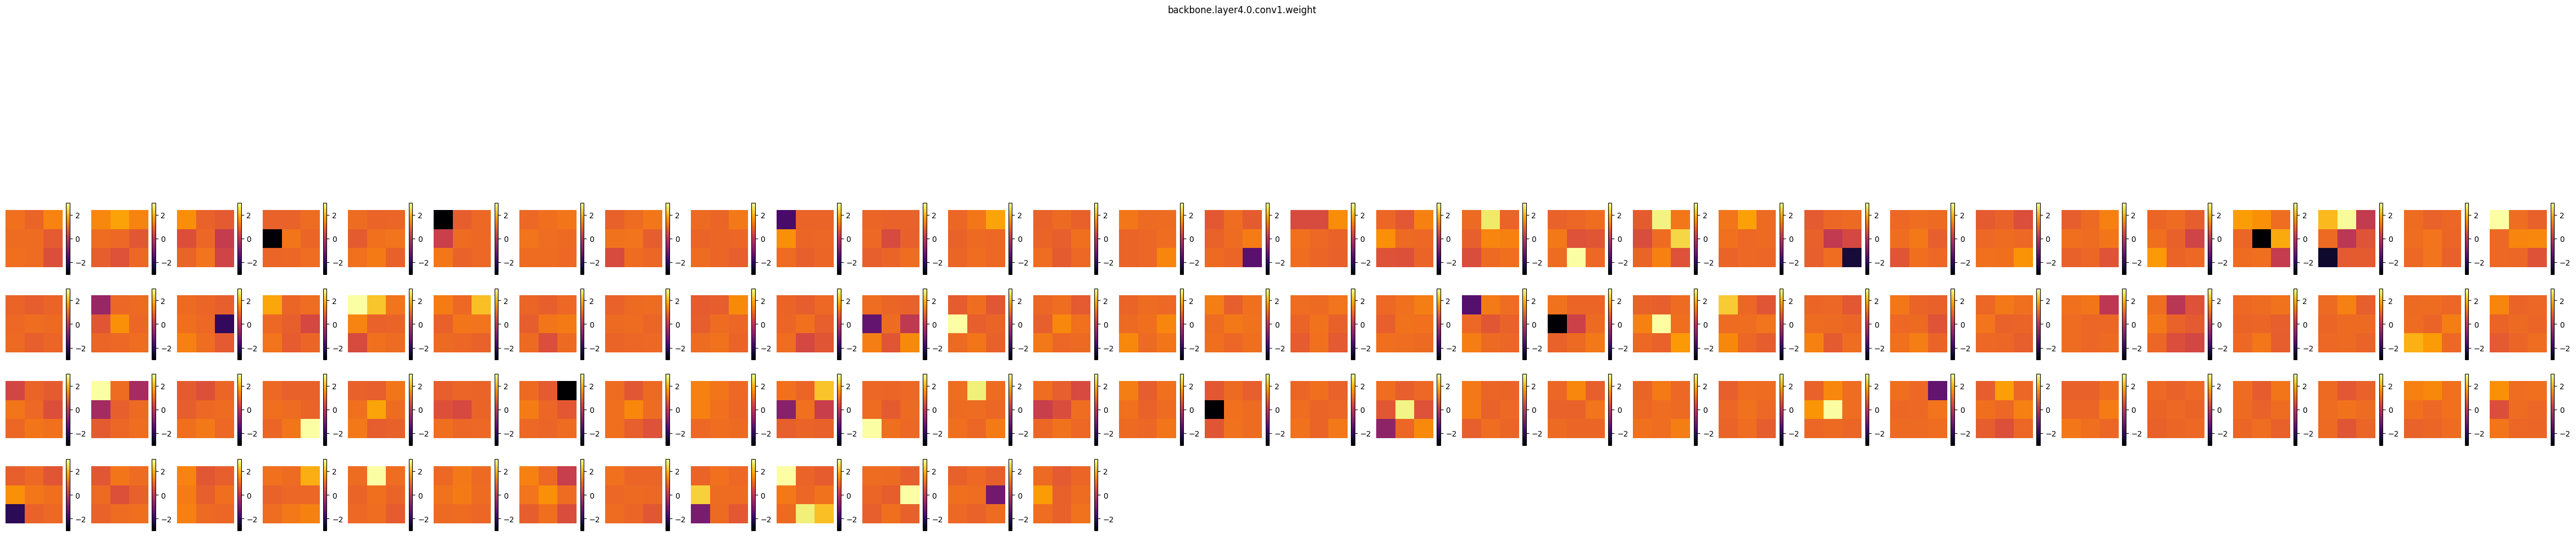

[SKIP] 1D layer: backbone.layer4.0.bn1.weight
[SKIP] 1D layer: backbone.layer4.0.bn1.bias


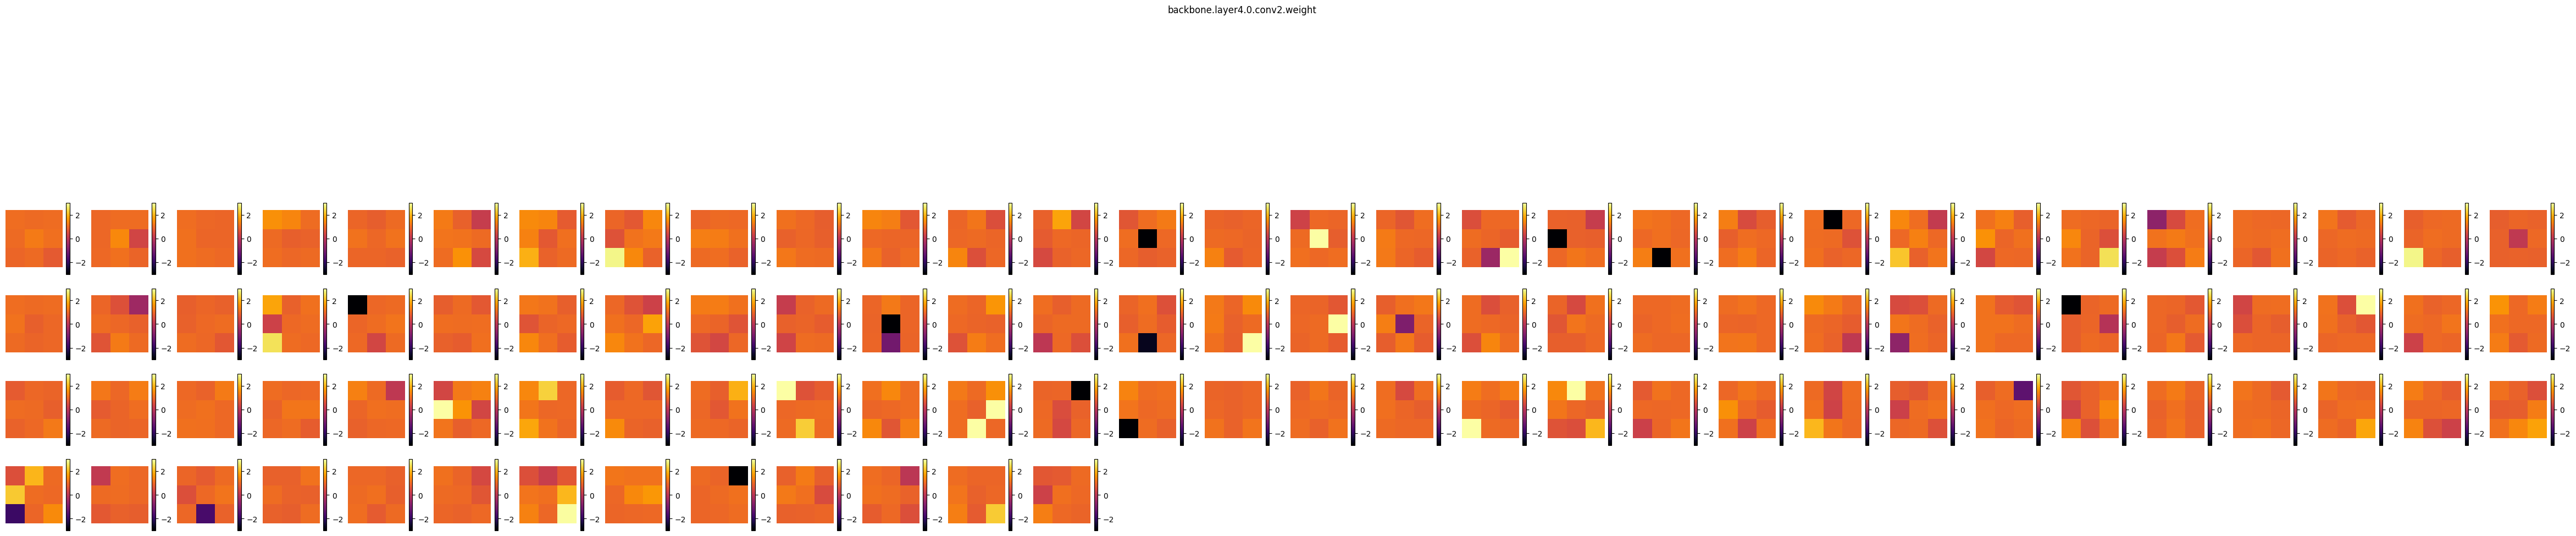

[SKIP] 1D layer: backbone.layer4.0.bn2.weight
[SKIP] 1D layer: backbone.layer4.0.bn2.bias


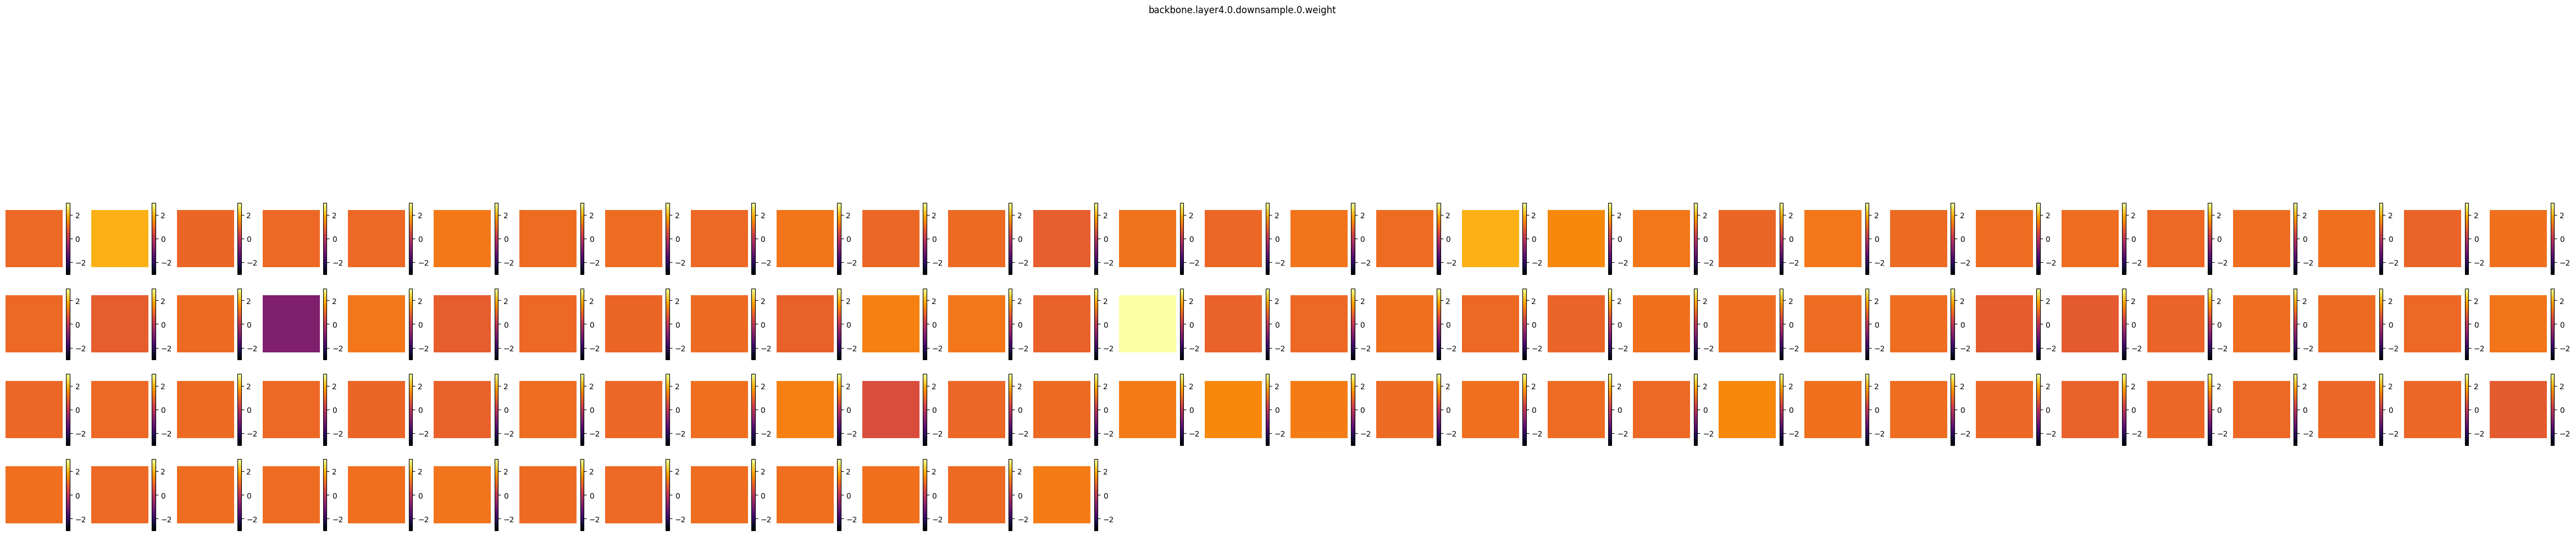

[SKIP] 1D layer: backbone.layer4.0.downsample.1.weight
[SKIP] 1D layer: backbone.layer4.0.downsample.1.bias


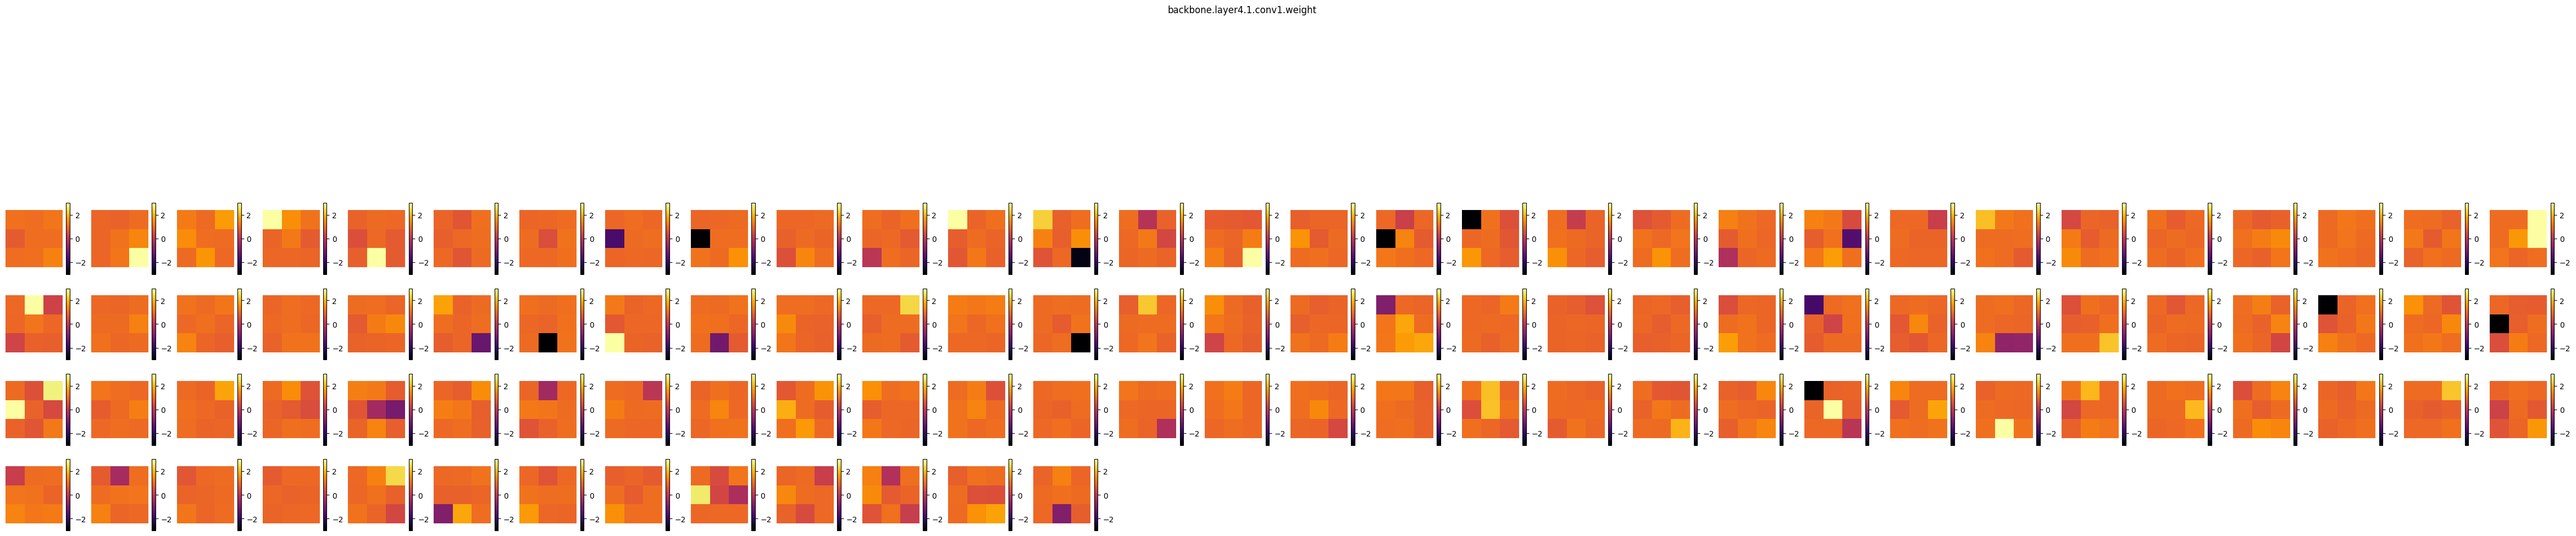

[SKIP] 1D layer: backbone.layer4.1.bn1.weight
[SKIP] 1D layer: backbone.layer4.1.bn1.bias


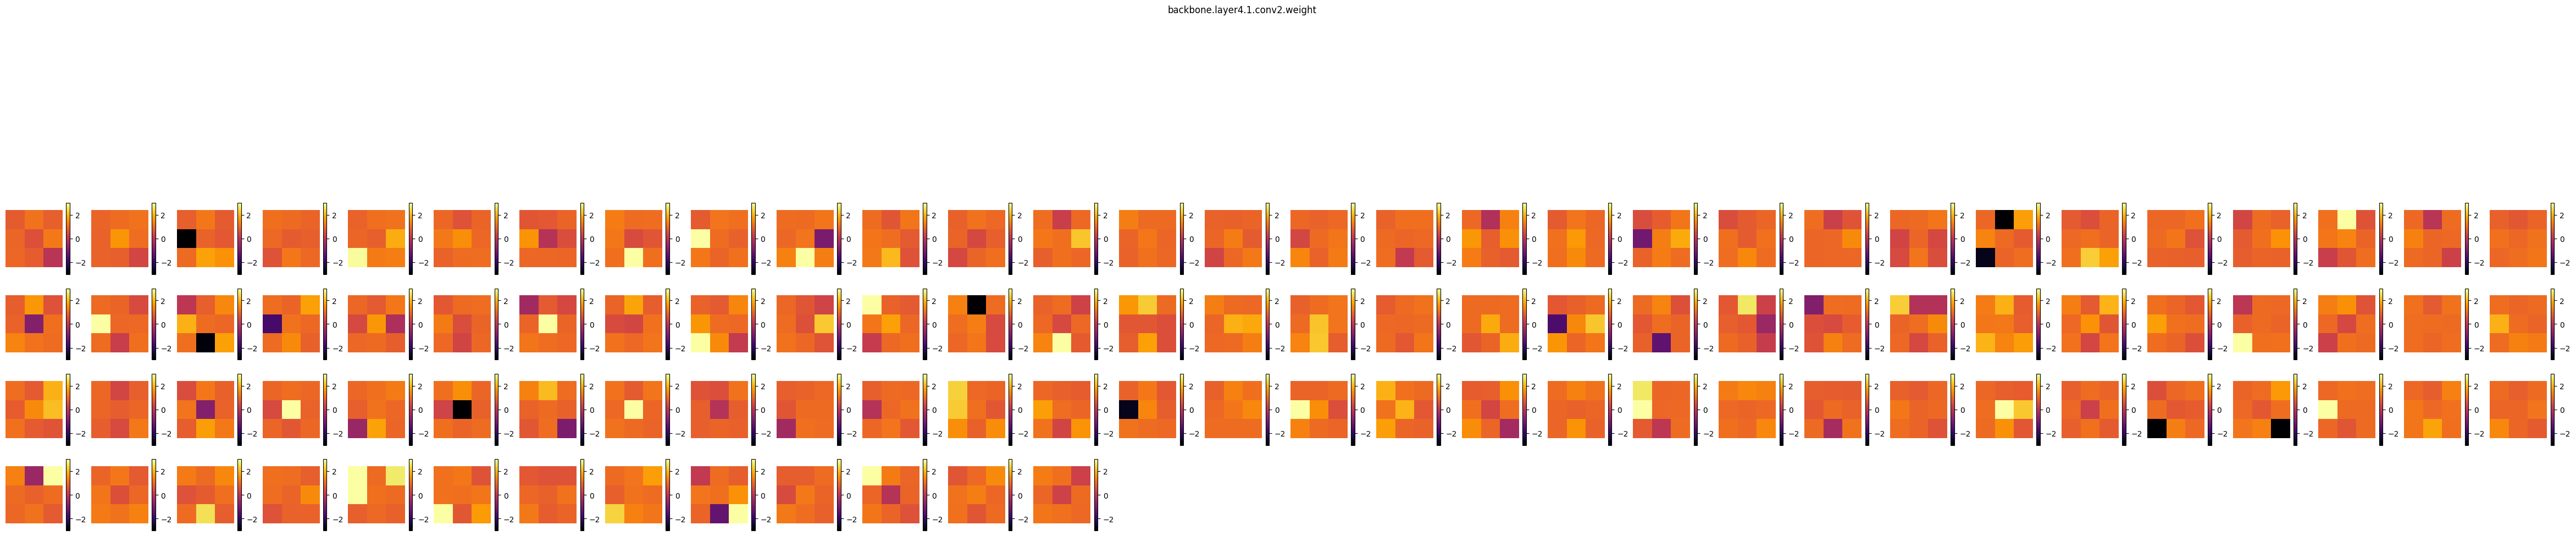

[SKIP] 1D layer: backbone.layer4.1.bn2.weight
[SKIP] 1D layer: backbone.layer4.1.bn2.bias
Saved t-SNE figure to: weights_comparison_ref_feattemp


<Figure size 640x480 with 0 Axes>

In [17]:
weights_comparison(reference_extractor,feature_extractor_temp)


In [16]:
def load_crops(root_dir):

    cropped_dir = os.path.join(root_dir, "images_cropped")
    label_dir = os.path.join(root_dir, "labels")
    crops, class_ids = [], []
    class_count = {}

    for fname in tqdm(sorted(os.listdir(cropped_dir)), desc="Loading cropped images"):
        if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(cropped_dir, fname)
        cls = int(fname.split("cls")[-1].split(".")[0])
        img = Image.open(img_path).convert("RGB")

        crops.append(img)
        class_ids.append(cls)

        class_count[cls] = class_count.get(cls, 0) + 1

    print("\n📊 Class distribution in images_cropped/:")
    for cls in sorted(class_count.keys()):
        print(f"  Class {cls:>3}  →  {class_count[cls]} images")

    print(f"\nTotal classes: {len(class_count)}")
    print(f"Total images : {len(class_ids)}\n")

    return crops, class_ids

In [39]:
import random
import numpy as np
import torch
import torch.nn.functional as F


class YoloCroppedEvaluator:
    def __init__(self, model, crops, class_ids, device="cuda"):
        self.model = model.to(device)
        self.model.eval()
        self.device = device
        self.transform = conversion_transform
        self.crops = crops
        self.class_ids = class_ids

    def compute_embeddings(self):
        tensors = torch.stack([self.transform(img) for img in self.crops]).to(self.device)
        with torch.no_grad():
            feats = self.model(tensors)
            feats = F.normalize(feats, dim=1)
        return feats

    def build_reference_bank(self, feats, class_ids, rng=None):
        if rng is None:
            rng = random

        class_to_indices = {}
        for i, cls in enumerate(class_ids):
            class_to_indices.setdefault(cls, []).append(i)

        refs = {}
        for cls, idxs in class_to_indices.items():
            ref_idx = rng.choice(idxs)
            refs[cls] = feats[ref_idx]

        return refs, class_to_indices

    def classify_once(self, feats, class_ids, seed=None):
        if seed is not None:
            rng = random.Random(seed)
        else:
            rng = random

        refs, class_to_indices = self.build_reference_bank(feats, class_ids, rng)
        ref_mat = torch.stack(list(refs.values()))
        ref_classes = list(refs.keys())

        sims = feats @ ref_mat.T
        preds = sims.argmax(dim=1)
        predicted_classes = [ref_classes[i] for i in preds.cpu().numpy()]

        correct = sum([p == gt for p, gt in zip(predicted_classes, class_ids)])
        acc = correct / len(class_ids)
        return acc

    def evaluate_average_accuracy(self, crops, class_ids, feats, n_runs=20, base_seed=42,Title=""):
        accuracies = []
        for i in range(n_runs):
            acc = self.classify_once(feats, class_ids, seed=base_seed + i)
            accuracies.append(acc)

        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)

        print(f"{Title}\nMean accuracy over {n_runs} runs: {mean_acc*100:.2f}% ± {std_acc*100:.2f}%")

        return mean_acc, std_acc


In [20]:
root_dir="./firefighting-device-detection/valid"
valid_crops, valid_class_ids=load_crops(root_dir)


Loading cropped images: 100%|██████████| 755/755 [00:00<00:00, 5132.84it/s]


📊 Class distribution in images_cropped/:
  Class   0  →  295 images
  Class   1  →  34 images
  Class   2  →  2 images
  Class   3  →  48 images
  Class   4  →  42 images
  Class   5  →  25 images
  Class   7  →  5 images
  Class   8  →  7 images
  Class  10  →  3 images
  Class  11  →  1 images
  Class  12  →  1 images
  Class  13  →  10 images
  Class  14  →  12 images
  Class  15  →  74 images
  Class  16  →  35 images
  Class  17  →  2 images
  Class  18  →  1 images
  Class  20  →  6 images
  Class  21  →  37 images
  Class  22  →  9 images
  Class  23  →  7 images
  Class  24  →  34 images
  Class  25  →  13 images
  Class  27  →  5 images
  Class  28  →  5 images
  Class  29  →  1 images
  Class  30  →  1 images
  Class  32  →  1 images
  Class  33  →  12 images
  Class  34  →  9 images
  Class  36  →  5 images
  Class  39  →  12 images
  Class  40  →  1 images

Total classes: 33
Total images : 755



In [38]:
evaluator_ref_temp = YoloCroppedEvaluator(reference_extractor, crops=valid_crops, class_ids=valid_class_ids ,device=device)
evaluator_temp = YoloCroppedEvaluator(feature_extractor_temp, crops=valid_crops, class_ids=valid_class_ids, device=device)


To evaluate how training modifies the representation space, we project the validation embeddings into 2-D using t-SNE.
t-SNE preserves local neighborhood structure, so samples that are close in the original embedding space remain close after projection.
This allows us to visually assess whether the training makes the embeddings more structured.
We also compare this visualization to the one obtained with our reference extractor (before contrastive training).
The following figure shows the t-SNE projection of the embeddings produced by our trained model

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne(feats, class_ids, perplexity=30, save_path=None,title="t-SNE Embeddings"):
    """
    feats: torch.Tensor of shape (N, D)
    class_ids: list or array of length N
    """

    X = feats.cpu().numpy()
    y = np.array(class_ids)

    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate="auto",
        init="random"
    )
    X_2d = tsne.fit_transform(X)

    plt.figure(figsize=(10, 8))

    unique_classes = np.unique(y)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_classes)))

    for cls, color in zip(unique_classes, colors):
        idx = (y == cls)
        plt.scatter(
            X_2d[idx, 0],
            X_2d[idx, 1],
            c=[color],
            s=15,
            alpha=0.8,
            label=str(cls)
        )

    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")

    plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved t-SNE figure to: {save_path}")

    plt.show()


In [24]:
feats_ref = evaluator_ref_temp.compute_embeddings()
feats_temp = evaluator_temp.compute_embeddings()


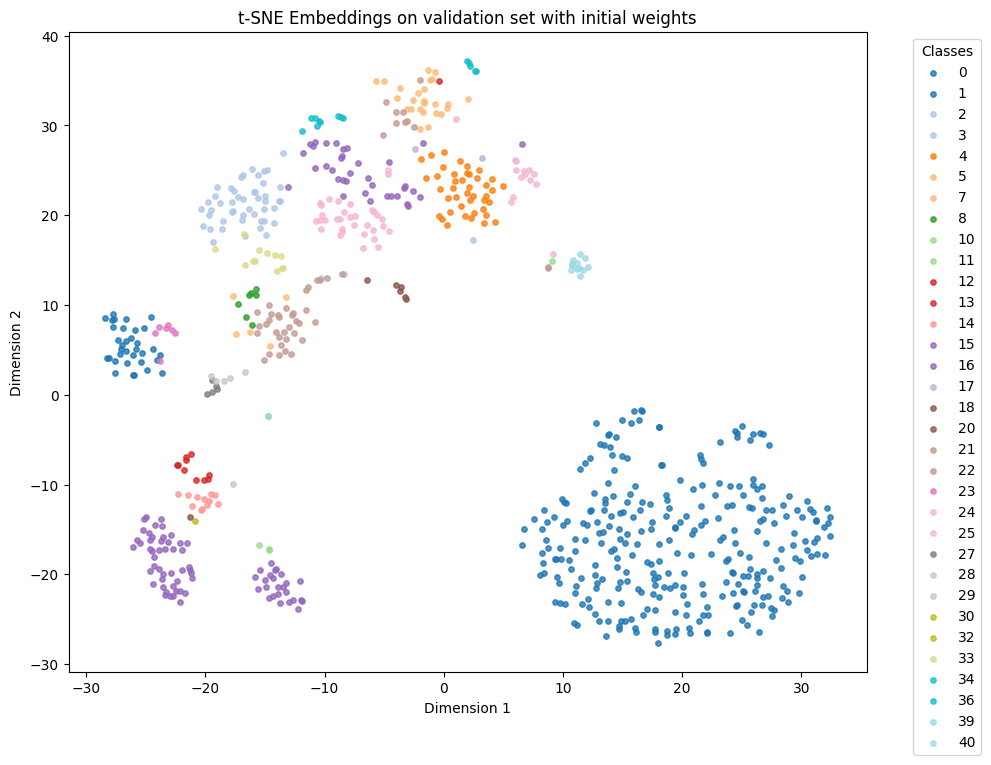

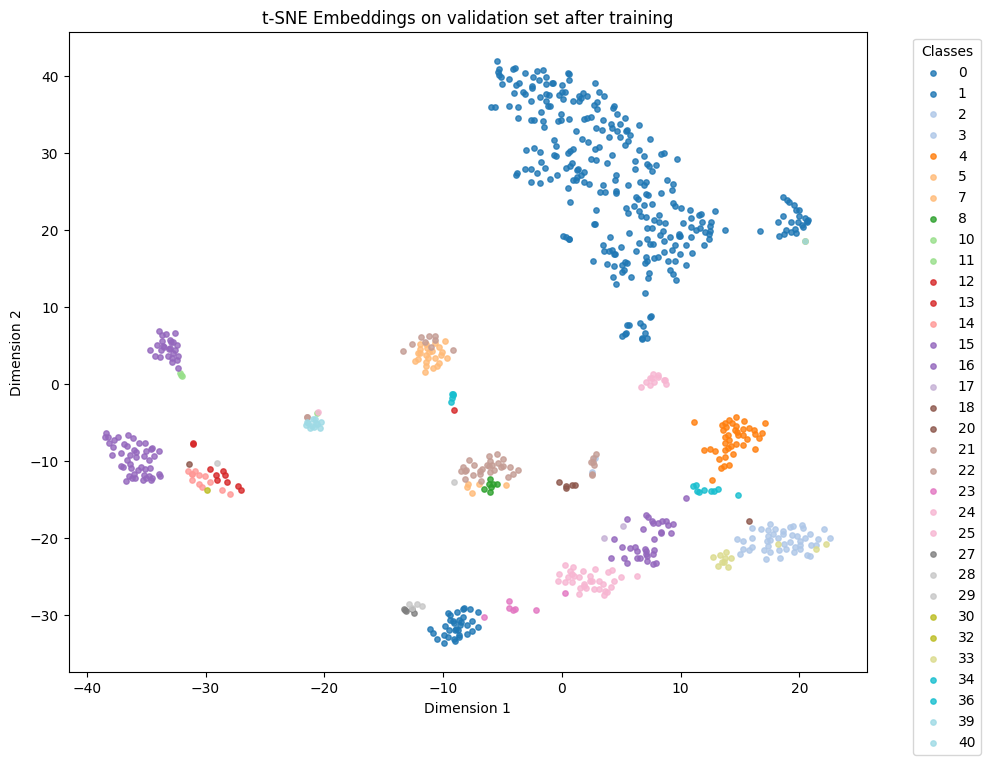

In [55]:
plot_tsne(feats=feats_ref, class_ids=valid_class_ids, title="t-SNE Embeddings on validation set with initial weights")
plot_tsne(feats=feats_temp, class_ids=valid_class_ids, title="t-SNE Embeddings on validation set after training")


The clusters become slightly more compact after training, while preserving their overall structure.  
This indicates that the chosen hyperparameters improved the representation quality without breaking the natural class groupings.




Below we show the embeddings obtained with the same setup as before, but using:
- **temperature = 0.1**
- **15 training epochs**

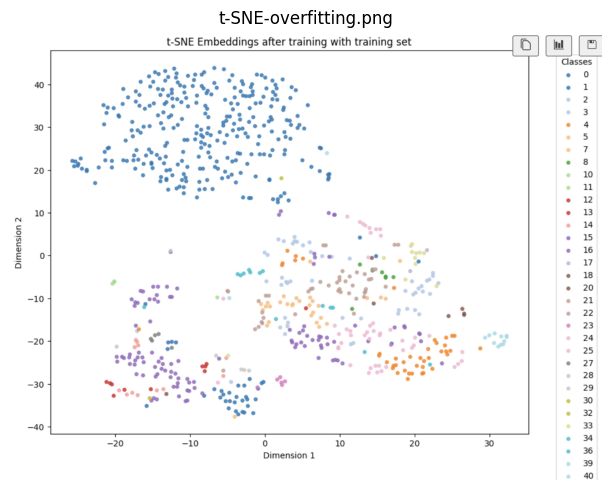

In [26]:
images = [
    "t-SNE-overfitting.png"]

plt.figure(figsize=(20, 5))

for i, img_path in enumerate(images):
    img = mpimg.imread(img_path)
    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_path)

plt.tight_layout()
plt.show()

This visualization explains why a **too low temperature** or **training for too many epochs** causes the embeddings to spread excessively.  
With overly strong repulsion, points that should remain close (same-class samples) are pushed far apart, fragmenting the natural clusters.  
Even if the contrastive loss decreases, the representation space becomes distorted and less useful for downstream classification.
This make sense since self-supervised contrastive learning is label-agnostic. It only tries to pull augmented views of the same image together and push different images apart. It does not explicitly try to align samples belonging to the same semantic class.

### Evaluation of the accuracy on the validation set

To quantify how well the learned embeddings separate the classes, we compute the mean accuracy of our model and compare it with the reference extractor.
For each class, we randomly select one sample as the representative and classify all other samples using a 1-nearest-neighbor classifier based on cosine similarity in the embedding space.
This procedure, instead of using class centroids (mean embeddings), better reflects a realistic scenario in which a user provides one arbitrary photo of an object, and the system must generalize from that example.
We repeat the process multiple times with different random exemplars and report the mean and standard deviation of the accuracy.

In [40]:
validation_mean_acc, validation_std_acc = evaluator_ref_temp.evaluate_average_accuracy(crops = valid_crops, class_ids=valid_class_ids,feats=feats_ref,n_runs=200)
validation_mean_acc, validation_std_acc = evaluator_temp.evaluate_average_accuracy(crops = valid_crops, class_ids=valid_class_ids,feats=feats_temp,n_runs=200)


Mean accuracy over 200 runs: 67.60% ± 7.37%

Mean accuracy over 200 runs: 73.48% ± 8.47%


Our contrastive model achieves slightly better accuracy than the reference extractor.  
With the chosen hyperparameters, all models trained for **1 to 5 epochs** consistently improve accuracy by **5–7%**, which is a solid gain.

However, it is difficult to pinpoint which epoch gives the “best” model.  
There is significant variance due to:
- the randomness of the 1-NN evaluation,
- some classes having very few examples, which increases the noise in accuracy estimates.

Given this uncertainty, we keep and evaluate all models from 1 to 5 epochs on the test set.



###  Final Training Configuration

Given the results obtained from the validation, I made the following choices for the final training:

- **Base model:** `resnet18`  
- **Embedding dimension (`out_dim`):** `128`  
- **Temperature:** `0.6`  
- **Batch size:** `64`  
- **Learning rate (`lr`):** `0.0001` (with scheduler decreasing down to `0.2 × lr`)  
- **Weight decay:** `1e-6`  
- **Epochs:** `5` — model weights are saved every 5 epochs as a backup.


In [ ]:
'''Once best hyperparameters identified, training on training+validation'''


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr=0.0001
temperature=0.6
base_model='resnet18'
out_dim=128
weight_decay=1e-6
batch_size=64
num_epochs=5
adam_with_weight_decay=True
with_scheduler=True


model_f = ResNetSimCLR(base_model=base_model,out_dim=out_dim).to(device)

for name, param in model_f.backbone.named_parameters():
    param.requires_grad = False

for name, param in model_f.backbone.layer4.named_parameters():
    param.requires_grad = True

for name, param in model_f.backbone.fc.named_parameters():
    param.requires_grad = True

params_to_train = [p for p in model_f.parameters() if p.requires_grad]



criterion = NTXentLoss(temperature=temperature)

if adam_with_weight_decay:
  optimizer = optim.AdamW(params_to_train, lr=lr, weight_decay=weight_decay)
else:
  optimizer = optim.Adam(params_to_train, lr=lr)

if with_scheduler:
  def warmup_cosine_scheduler(optimizer, num_epochs, warmup_ratio=0.1, lr_min_ratio=0.2):
      warmup_epochs = int(num_epochs * warmup_ratio)
      cosine_epochs = num_epochs - warmup_epochs

      def lr_lambda(epoch):
          if epoch < warmup_epochs:
              return epoch / warmup_epochs
          else:
              progress = (epoch - warmup_epochs) / cosine_epochs
              cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
              return lr_min_ratio + (1 - lr_min_ratio) * cosine_decay

      return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

  scheduler = warmup_cosine_scheduler(optimizer, num_epochs=num_epochs)
    

train_set=CroppedSimCLRDataset(root_dir="./firefighting-device-detection/train",transform=transform)
validation_set=CroppedSimCLRDataset(root_dir="./firefighting-device-detection/valid",transform=transform)


full_dataset = torch.utils.data.ConcatDataset([train_set, validation_set])
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True,num_workers=4,pin_memory=True,persistent_workers=True)


for epoch in range(num_epochs):
    model_f.train()
    running_loss = 0.0
    for images_T1, images_T2 in full_loader:
        images_T1, images_T2 = images_T1.to(device), images_T2.to(device)
        outputs_T1 = model_f(images_T1)
        outputs_T2 = model_f(images_T2)
        loss = criterion(outputs_T1, outputs_T2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if with_scheduler:
      scheduler.step()
    print(f"Final training loss epoch {epoch+1}: {running_loss/len(full_loader):.4f}")
    checkpoint_path = f"final_model_epoch{epoch+1}.pth"
    torch.save({
        "epoch": epoch + 1,
        "model_state_dict": model_f.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict() if with_scheduler else None,
    }, checkpoint_path)
    print(f"💾 Saved checkpoint: {checkpoint_path}")

if with_scheduler:
  if adam_with_weight_decay:
    filename = f"final_weights_adamw_scheduler_model={base_model}_out{out_dim}_batch{batch_size}_temperature{temperature}_lr{lr}_epoch{num_epochs}.pth"
  else:
    filename = f"final_weights_scheduler_model={base_model}_out{out_dim}_batch{batch_size}_temperature{temperature}_lr{lr}_epochs{num_epochs}.pth"
else:
  if adam_with_weight_decay:
    filename = f"final_weights_adamw_model={base_model}_out{out_dim}_batch{batch_size}_temperature{temperature}_lr{lr}_epochs{num_epochs}.pth"
  else:
    filename = f"final_weights_model={base_model}_out{out_dim}_batch{batch_size}_temperature{temperature}_lr{lr}_epochs{num_epochs}.pth"
torch.save(model_f.state_dict(), filename)

### Model Used for Testing

Below is the code to directly loads the weights of the model I used for testing.
The projection head is removed for inference, keeping only the backbone as the feature extractor.


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model='resnet18'
out_dim=128


reference_extractor = ResNetSimCLR(base_model=base_model,out_dim=out_dim).to(device)
reference_extractor.backbone.fc = nn.Identity()  
final_feature_extractor = ResNetSimCLR(base_model=base_model,out_dim=out_dim).to(device)
weights_file="final_model_epoch5.pth"
ckpt = torch.load(weights_file, map_location='cpu')
final_feature_extractor.load_state_dict(ckpt["model_state_dict"], strict=True)
final_feature_extractor.backbone.fc = nn.Identity()


/var/folders/t9/q84x_b1n3xjgf7jpkdvlr4n00000gn/T/ipykernel_58851/453047185.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(weights_file, map_location=

In [ ]:
weights_comparison(reference_extractor,final_feature_extractor)

###  One-Shot Evaluation Protocol

- We take the cropped images from the testing set.  
- All images are embedded using the trained model.  
- For each class, we randomly select one vector within that class as the reference (one-shot).  
  - Using the average vector per class could yield better accuracy, but in real conditions, the user would only provide a single random example per label.
- I added seed for reproductibility  


- We identify **40 classes** among **430 examples**.  
- Finally, we compare the **average accuracy** with the one obtained using the **ResNet backbone extractor**.


In [44]:
test_crops, test_class_ids=load_crops("./firefighting-device-detection/test")

Loading cropped images: 100%|██████████| 424/424 [00:00<00:00, 5315.23it/s]


📊 Class distribution in images_cropped/:
  Class   0  →  149 images
  Class   1  →  17 images
  Class   2  →  3 images
  Class   3  →  25 images
  Class   4  →  25 images
  Class   5  →  4 images
  Class   7  →  5 images
  Class   8  →  5 images
  Class   9  →  1 images
  Class  11  →  3 images
  Class  14  →  9 images
  Class  15  →  59 images
  Class  16  →  19 images
  Class  17  →  5 images
  Class  19  →  1 images
  Class  21  →  22 images
  Class  22  →  7 images
  Class  23  →  3 images
  Class  24  →  16 images
  Class  25  →  13 images
  Class  27  →  5 images
  Class  28  →  9 images
  Class  29  →  3 images
  Class  31  →  1 images
  Class  32  →  2 images
  Class  33  →  2 images
  Class  34  →  4 images
  Class  37  →  1 images
  Class  39  →  4 images
  Class  40  →  2 images

Total classes: 30
Total images : 424



In [45]:
reference_evaluator = YoloCroppedEvaluator(reference_extractor, crops=test_crops, class_ids=test_class_ids, device=device)
final_evaluator = YoloCroppedEvaluator(final_feature_extractor, crops=test_crops, class_ids=test_class_ids, device=device)

In [47]:
final_ref_feats = reference_evaluator.compute_embeddings()
final_feats = final_evaluator.compute_embeddings()

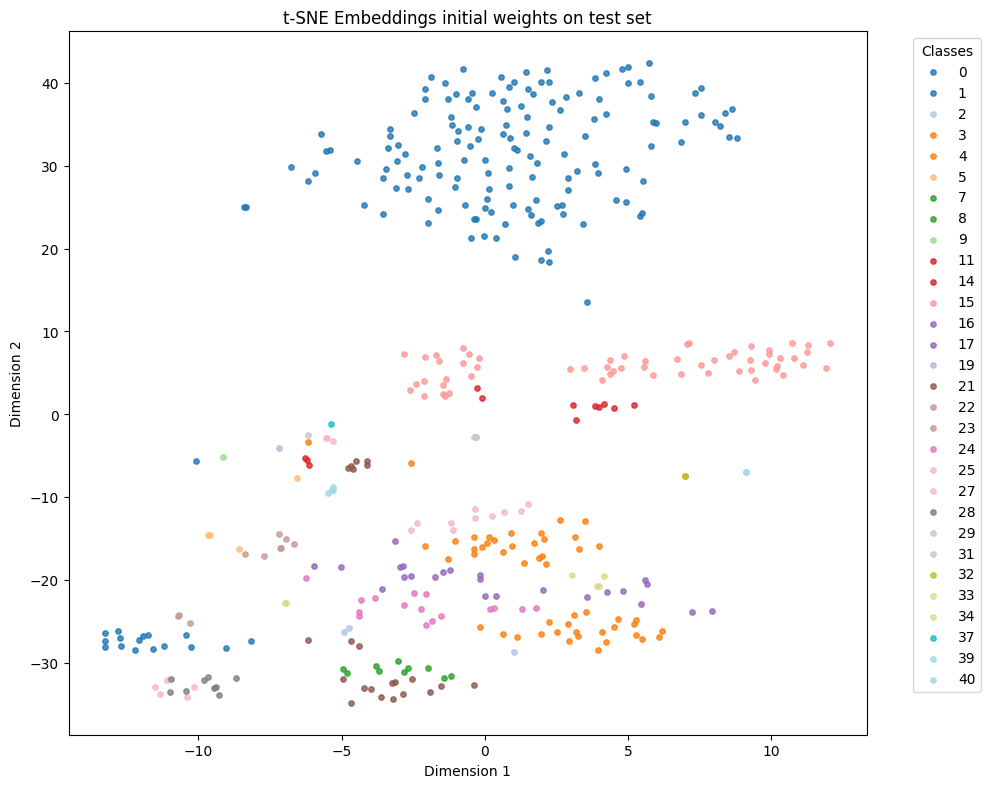

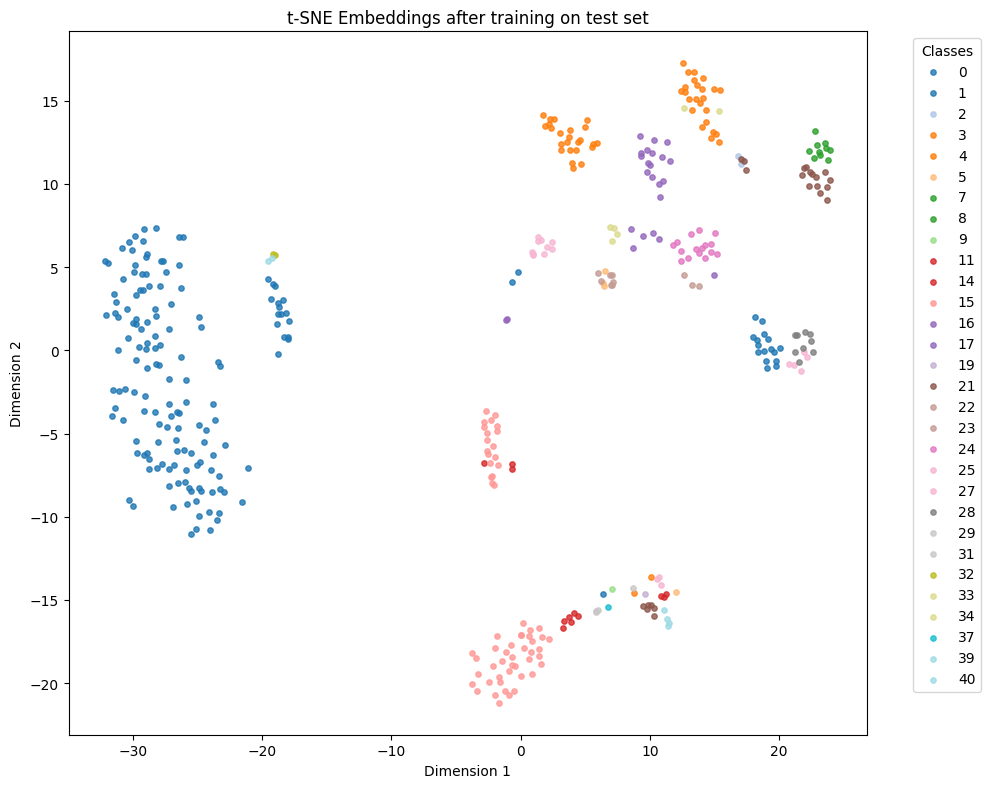

In [ ]:
plot_tsne(final_ref_feats, test_class_ids,title="t-SNE Embeddings initial weights on test set")
plot_tsne(final_feats, test_class_ids,title="t-SNE Embeddings after training on test set")

As with the validation set, we seem to have more compact clusters. That means that our choice of hyperparameters generalizes well

In [53]:
mean_acc, std_acc = reference_evaluator.evaluate_average_accuracy(crops = test_crops, class_ids=test_class_ids,feats=final_ref_feats,n_runs=30,Title="Before training")
mean_acc, std_acc = final_evaluator.evaluate_average_accuracy(crops = test_crops, class_ids=test_class_ids,feats=final_feats,n_runs=30,Title="After training")

Before training
Mean accuracy over 30 runs: 67.92% ± 5.35%
After training
Mean accuracy over 30 runs: 68.79% ± 8.13%


### Discussion on the Accuracy Results

The accuracy does not seem to have improved significantly.  
However, this outcome should be interpreted with caution for several reasons:

- **The test set is very small**, which makes the evaluation inherently unstable and highly sensitive to sample selection.
- **The one-shot / 1-NN protocol is extremely noisy**: choosing a single random reference example per class introduces a lot of variance, even when repeating the evaluation many times.
- Despite this, **the qualitative analysis is encouraging**.  
  The t-SNE visualizations show that the learned embedding generalizes well and produces a noticeably clearer class separation compared to the initial backbone features.
- Ultimately, this improved structure in the feature space is likely more meaningful than the raw 1-NN accuracy, given the limited evaluation setup.



## Conclusion



This work highlights several key points when adapting a pre-trained model using a contrastive approach:

- **ImageNet weights already produce reasonably well-formed clusters**, so we must avoid disrupting them too much.  
  This justifies using **gentle hyperparameters**, **few epochs**, and a generally cautious training setup to preserve the existing structure of the feature space.

- We also observed that **a decreasing contrastive loss is not a reliable indicator of good generalization**.  
  A lower loss does not necessarily translate into a better feature extractor.  
  In practice, **visualizing the embeddings (t-SNE)** was essential to properly assess the quality of the learned representations.

- Although the improvement did not translate into a clear gain in 1-NN accuracy (a very noisy protocol, especially with a small test set),  
  **the clusters after training were noticeably more compact and better separated**.  
  This suggests that the embedding improved, even if the metric did not reflect it directly.

- A potentially stronger approach would be **supervised contrastive learning**,  
  where pairs of different images with the same label are treated as positives.  
  This method typically yields stronger classification performance, but **it requires labels during training**,  
  which goes beyond the strictly self-supervised setup explored here.




